Bert Data Embedding and Implementation of Topological Sort 





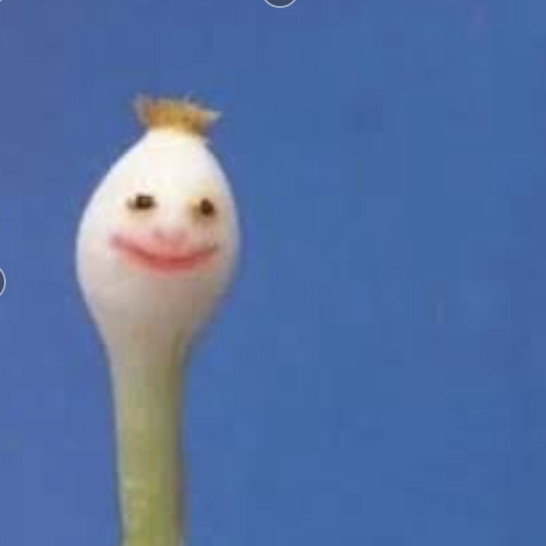

# Bert Embedding

In [132]:
# if run from here
# mount it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import pickle
FILE_NAME = '/content/drive/MyDrive/STAT946/DC2/data/kaggle data/train.pkl'
infile = open(FILE_NAME,'rb')
trainset = pickle.load(infile)

In [134]:
# store all the train orders
indexes = []
for instance in trainset:
  indexes.append(instance['indexes'])

In [140]:
filehandler = open('/content/drive/MyDrive/STAT946/DC2/data2/trainset_indexes.pkl',"wb")
pickle.dump(indexes, filehandler)
filehandler.close()

In [141]:
!pip install transformers

In [142]:
from transformers import BertTokenizer, RobertaTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# encoded_sentences = tokenizer.encode_plus(s1, s2, 
#                       max_length = 100, 
#                       truncation= True,
#                       add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                       return_attention_mask = True,
#                       return_token_type_ids = True,
#                       pad_to_max_length = True,
#                       return_tensors = 'pt')
# print(encoded_sentences['input_ids'])
# print(encoded_sentences['attention_mask'])
# print(encoded_sentences['token_type_ids'])

In [143]:
def bert_tokenization(dataset):
  # for each set
  input_ids = []
  labels = []
  attention_masks = []
  token_type_ids = []

  counter = 0
  for instance in dataset:
    if counter % 1000 == 0: print('current step is =: ', counter)
    counter = counter + 1 

    indexes = instance['indexes']
    inputs_set = []
    labels_set = []
    attention_mask_set = []
    token_type_id_set = []
    for i in range(0,6):
      for j in range(i+1,6):
        s1 = instance['sentences'][i]
        s2 = instance['sentences'][j]
        encoded_sentences = tokenizer.encode_plus(s1, s2, 
                          max_length = 100, 
                          truncation= True,
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          return_attention_mask = True,
                          return_token_type_ids = True,
                          pad_to_max_length = True,
                          return_tensors = 'pt')
        input = encoded_sentences['input_ids']
        attention_mask = encoded_sentences['attention_mask']
        token_type_id = encoded_sentences['token_type_ids']

        inputs_set.append(input)
        attention_mask_set.append(attention_mask)
        token_type_id_set.append(token_type_id)
        # if s1 is before s2, label = 1, else label = 0
        # index1 = indexes.index(i)
        # index2 = indexes.index(j)
        index1 = indexes[i]
        index2 = indexes[j]
        if (index1 < index2):
          label = 1
        else: 
          label = 0
        labels_set.append(label)
    input_ids.append(inputs_set)
    labels.append(labels_set)
    attention_masks.append(attention_mask_set)
    token_type_ids.append(token_type_id_set)
  return input_ids, attention_masks, token_type_ids, labels


In [144]:
len(trainset)

590226

In [145]:
n_size = 20000
input_ids, attention_masks, token_type_ids, labels = bert_tokenization(trainset[0:n_size])

current step is =:  0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


current step is =:  1000
current step is =:  2000
current step is =:  3000
current step is =:  4000
current step is =:  5000
current step is =:  6000
current step is =:  7000
current step is =:  8000
current step is =:  9000
current step is =:  10000
current step is =:  11000
current step is =:  12000
current step is =:  13000
current step is =:  14000
current step is =:  15000
current step is =:  16000
current step is =:  17000
current step is =:  18000
current step is =:  19000


In [146]:
len(input_ids), len(attention_masks), len(token_type_ids), len(labels)

(20000, 20000, 20000, 20000)

In [147]:
import torch
from torch.utils.data import TensorDataset, random_split
# convert input_ids 
for each in input_ids:
  each = torch.cat(each, dim=0)
b = torch.zeros([len(input_ids), 15, 100], dtype = torch.int32)
for i in range(0,len(input_ids)):
  for j in range(0,15):
    b[i][j] = input_ids[i][j]
input_ids = b
print(input_ids.shape) # torch.Size([1000, 15, 100])

# convert labels
c = torch.zeros([len(labels), 15], dtype = torch.int64)
for i in range(0,len(labels)):
  c[i] = torch.Tensor(labels[i])
labels = c
print(labels.shape) # torch.Size([1000, 15, 100])

# convert attention_masks
c = torch.zeros([len(attention_masks), 15, 100], dtype = torch.int32)
for i in range(0,len(attention_masks)):
  for j in range(0,15):
    c[i][j] = attention_masks[i][j]
attention_masks = c
print(attention_masks.shape) # torch.Size([1000, 15, 100])

# convert token type ids
c = torch.zeros([len(token_type_ids), 15, 100], dtype = torch.int32)
for i in range(0,len(token_type_ids)):
  for j in range(0,15):
    c[i][j] = token_type_ids[i][j]
token_type_ids = c
print(token_type_ids.shape) # torch.Size([1000, 15, 100])

torch.Size([20000, 15, 100])
torch.Size([20000, 15])
torch.Size([20000, 15, 100])
torch.Size([20000, 15, 100])


In [148]:
input_ids = input_ids.reshape(n_size*15,100)
attention_masks = attention_masks.reshape(n_size*15,100)
token_type_ids = token_type_ids.reshape(n_size*15,100)
labels = labels.reshape(n_size*15)

In [149]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
# dataset = TensorDataset(input_ids, attention_masks, token_type_ids, labels)

# # Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
set_train_size = int(0.9 * n_size)
train_size = set_train_size *15
val_size = (n_size - set_train_size)*15

print(train_size/15, val_size/15, train_size/15 + val_size/15)
print(train_size, val_size, train_size + val_size)
# Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # val_dataset = dataset.tensors[10000:11000]
# print("size of total: ", len(dataset))
# print("size of train: ", len(train_dataset))
# print("size of val: ", len(val_dataset))

18000.0 2000.0 20000.0
270000 30000 300000


In [150]:
train_dataset = TensorDataset(input_ids[:train_size], 
                              attention_masks[:train_size], 
                              token_type_ids[:train_size], 
                              labels[:train_size])
val_dataset = TensorDataset(input_ids[train_size:], 
                            attention_masks[train_size:], 
                            token_type_ids[train_size:], 
                            labels[train_size:])
len(train_dataset), len(val_dataset)

(270000, 30000)

In [ ]:


# filehandler = open('/content/drive/MyDrive/STAT946/DC2/top sort/pairs.pkl',"wb")
# pickle.dump(labels, filehandler)
# filehandler = open('/content/drive/MyDrive/STAT946/DC2/top sort/indexes.pkl',"wb")
# pickle.dump(indexes, filehandler)

In [151]:
torch.save(train_dataset, "/content/drive/MyDrive/STAT946/DC2/data2/train_dataset20000.pt")
torch.save(val_dataset, "/content/drive/MyDrive/STAT946/DC2/data2/val_dataset20000.pt")


# Topologocal Sort

In [87]:
from collections import defaultdict 
import csv
import ast
class Graph: 
    '''
    The code for this class is based on geeksforgeeks.com
    '''
    def __init__(self,vertices): 
        self.graph = defaultdict(list) 
        self.V = vertices 
  
    def addEdge(self, u, v): 
        self.graph[u].append([v]) 
    
    def topologicalSortUtil(self, v, visited, stack): 
  
        visited[v] = True
  
        for i in self.graph[v]: 
            if visited[i[0]] == False: 
                self.topologicalSortUtil(i[0], visited, stack) 
  
        stack.insert(0,v) 
  
    def topologicalSort(self): 
        visited = [False]*self.V 
        stack =[] 

        for i in range(self.V): 
            if visited[i] == False: 
                self.topologicalSortUtil(i, visited, stack) 
  
        return stack
        
    def isCyclicUtil(self, v, visited, recStack): 
  
        visited[v] = True
        recStack[v] = True
  
        for neighbour in self.graph[v]:
            if visited[neighbour[0]] == False: 
                if self.isCyclicUtil(
                    neighbour[0], visited, recStack) == True: 
                    return True
            elif recStack[neighbour[0]] == True: 
                self.graph[v].remove(neighbour)
                return True
  
        recStack[v] = False
        return False
  
    def isCyclic(self): 
        visited = [False] * self.V 
        recStack = [False] * self.V 
        for node in range(self.V): 
            if visited[node] == False: 
                if self.isCyclicUtil(node, visited, recStack) == True: 
                    return True
        return False

class Stats(object):
    
    def __init__(self):
        self.n_samp = 0
        self.n_sent = 0
        self.n_pair = 0
        self.corr_samp = 0
        self.corr_sent = 0
        self.corr_pair = 0
        self.lcs_seq = 0
        self.tau = 0
        self.dist_window = [1, 2, 3]
        self.min_dist = [0]*len(self.dist_window)
        
    def pairwise_metric(self, g):
        '''
        This  calculates the percentage of skip-bigrams for which the 
        relative order is predicted correctly. Rouge-S metric.
        '''
        common = 0
        for vert in range(g.V):
            to_nodes = g.graph[vert]
            to_nodes = [node[0] for node in to_nodes]
            gold_nodes = list(range(vert+1, g.V))
            common += len(set(gold_nodes).intersection(set(to_nodes)))

        return common
    
    def kendall_tau(self, porder, gorder):
        '''
        It calculates the number of inversions required by the predicted 
        order to reach the correct order.
        '''
        pred_pairs, gold_pairs = [], []
        for i in range(len(porder)):
            for j in range(i+1, len(porder)):
                pred_pairs.append((porder[i], porder[j]))
                gold_pairs.append((gorder[i], gorder[j]))
        common = len(set(pred_pairs).intersection(set(gold_pairs)))
        uncommon = len(gold_pairs) - common
        tau = 1 - (2*(uncommon/len(gold_pairs)))

        return tau
    
    def min_dist_metric(self, porder, gorder):
        '''
        It calculates the displacement of sentences within a given window.
        '''
        count = [0]*len(self.dist_window)
        for i in range(len(porder)):
            pidx = i
            pval = porder[i]
            gidx = gorder.index(pval)
            for w, window in enumerate(self.dist_window):
                if abs(pidx-gidx) <= window:
                    count[w] += 1
        return count
    
    def lcs(self, X , Y): 
        m = len(X) 
        n = len(Y) 

        L = [[None]*(n+1) for i in range(m+1)] 

        for i in range(m+1): 
            for j in range(n+1): 
                if i == 0 or j == 0 : 
                    L[i][j] = 0
                elif X[i-1] == Y[j-1]: 
                    L[i][j] = L[i-1][j-1]+1
                else: 
                    L[i][j] = max(L[i-1][j] , L[i][j-1]) 

        return L[m][n] 
    
    def sample_match(self, order, gold_order):
        '''
        It calculates the percentage of samples for which the entire 
        sequence was correctly predicted. (PMR)
        '''
        return order == gold_order
    
    def sentence_match(self, order, gold_order):
        '''
        It measures the percentage of sentences for which their absolute 
        position was correctly predicted. (Acc)
        '''
        return sum([1 for x in range(len(order)) if order[x] == gold_order[x]])
    
    def update_stats(self, nvert, npairs, order, gold_order, g):
        self.n_samp += 1
        self.n_sent += nvert
        self.n_pair += npairs
        
        if self.sample_match(order, gold_order):
            self.corr_samp += 1
        self.corr_sent += self.sentence_match(order, gold_order)
        self.corr_pair += self.pairwise_metric(g)
        self.lcs_seq += self.lcs(order, gold_order)
        self.tau += self.kendall_tau(order, gold_order)
        window_counts = self.min_dist_metric(order, gold_order)
        for w, wc in enumerate(window_counts):
            self.min_dist[w] += wc
        
    def print_stats(self):
        print("Perfect Match: " + str(self.corr_samp*100/self.n_samp))
        print("Sentence Accuracy: " + str(self.corr_sent*100/self.n_sent))
        print("Rouge-S: " + str(self.corr_pair*100/self.n_pair))
        print("LCS: " + str(self.lcs_seq*100/self.n_sent))
        print("Kendall Tau Ratio: " + str(self.tau/self.n_samp))
        for w, window in enumerate(self.dist_window):
            print("Min Dist Metric for window " + str(window) + ": " + \
                                    str(self.min_dist[w]*100/self.n_sent))



def get_pos(j):
  if (j>=0) & (j<=4): return 0, j+1
  if (j>=5) & (j<=8): return 1, j-3
  if (j>=9) & (j<=11): return 2, j-6
  if (j>=12) & (j<=13): return 3, j-8
  else: return 4, 5

def topSort(data):
  orders = []
  for instance in data:
    g = Graph(6)
    for j in range(0,15):
      pred = instance[j]
      pos_s1, pos_s2 = get_pos(j)

      if pred == 1: 
        g.addEdge(pos_s1, pos_s2)
      if pred == 0: 
        g.addEdge(pos_s2, pos_s1)
    while g.isCyclic():
      g.isCyclic()

    sorted = g.topologicalSort()
    arr = []
    for i in range(0,6):
      arr.append(sorted.index(i))
  
    orders.append(arr)
  return orders

# Prepare test data

In [152]:
import pickle
FILE_NAME = '/content/drive/MyDrive/STAT946/DC2/data/kaggle data/test.pkl'
infile = open(FILE_NAME,'rb')
test = pickle.load(infile)

In [153]:
def bert_tokenization2(dataset):
  # for each set
  input_ids = []
  # labels = []
  attention_masks = []
  token_type_ids = []

  counter = 0
  for instance in dataset:
    if counter % 1000 == 0: print('current step is =: ', counter)
    counter = counter + 1 

    # indexes = instance['indexes']
    inputs_set = []
    # labels_set = []
    attention_mask_set = []
    token_type_id_set = []
    for i in range(0,6):
      for j in range(i+1,6):
        s1 = instance['sentences'][i]
        s2 = instance['sentences'][j]
        encoded_sentences = tokenizer.encode_plus(s1, s2, 
                          max_length = 100, 
                          truncation= True,
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          return_attention_mask = True,
                          return_token_type_ids = True,
                          pad_to_max_length = True,
                          return_tensors = 'pt')
        input = encoded_sentences['input_ids']
        attention_mask = encoded_sentences['attention_mask']
        token_type_id = encoded_sentences['token_type_ids']

        inputs_set.append(input)
        attention_mask_set.append(attention_mask)
        token_type_id_set.append(token_type_id)
        # if s1 is before s2, label = 1, else label = 0
        # index1 = indexes.index(i)
    #     index2 = indexes.index(j)
    #     if (index1 < index2):
    #       label = 1
    #     else: 
    #       label = 0
    #     labels_set.append(label)
    input_ids.append(inputs_set)
    # labels.append(labels_set)
    attention_masks.append(attention_mask_set)
    token_type_ids.append(token_type_id_set)
  return input_ids, attention_masks, token_type_ids


In [154]:
input_ids, attention_masks, token_type_ids = bert_tokenization2(test)

current step is =:  0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


current step is =:  1000


In [155]:
print(len(input_ids), len(attention_masks), len(token_type_ids))

2000 2000 2000


In [156]:
import torch
from torch.utils.data import TensorDataset, random_split
# convert input_ids 
for each in input_ids:
  each = torch.cat(each, dim=0)
b = torch.zeros([len(input_ids), 15, 100], dtype = torch.int32)
for i in range(0,len(input_ids)):
  for j in range(0,15):
    b[i][j] = input_ids[i][j]
input_ids = b
print(input_ids.shape) # torch.Size([1000, 15, 100])

# # convert labels
# c = torch.zeros([len(labels), 15], dtype = torch.int64)
# for i in range(0,len(labels)):
#   c[i] = torch.Tensor(labels[i])
# labels = c
# print(labels.shape) # torch.Size([1000, 15, 100])

# convert attention_masks
c = torch.zeros([len(attention_masks), 15, 100], dtype = torch.int32)
for i in range(0,len(attention_masks)):
  for j in range(0,15):
    c[i][j] = attention_masks[i][j]
attention_masks = c
print(attention_masks.shape) # torch.Size([1000, 15, 100])

# convert token type ids
c = torch.zeros([len(token_type_ids), 15, 100], dtype = torch.int32)
for i in range(0,len(token_type_ids)):
  for j in range(0,15):
    c[i][j] = token_type_ids[i][j]
token_type_ids = c
print(token_type_ids.shape) # torch.Size([1000, 15, 100])

torch.Size([2000, 15, 100])
torch.Size([2000, 15, 100])
torch.Size([2000, 15, 100])


In [157]:
input_ids = input_ids.reshape(2000*15,100)
attention_masks = attention_masks.reshape(2000*15,100)
token_type_ids = token_type_ids.reshape(2000*15,100)

In [158]:
test_dataset = TensorDataset(input_ids, attention_masks, token_type_ids)

In [159]:
torch.save(test_dataset, '/content/drive/MyDrive/STAT946/DC2/data2/test_dataset.pt' )

# Unused model

In [ ]:
import torch
# if run from here
# mount it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset=torch.load("/content/drive/MyDrive/STAT946/DC2/data2/train_dataset.pt")
val_dataset=torch.load("/content/drive/MyDrive/STAT946/DC2/data2/val_dataset.pt")

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Setup CUDA, GPU & distributed training
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU


Gen RAM Free: 26.2 GB  | Proc size: 326.2 MB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total 16280MB


In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 24.4 GB  | Proc size: 3.6 GB
GPU RAM Free: 14913MB | Used: 1367MB | Util   8% | Total 16280MB


In [ ]:
from transformers import (WEIGHTS_NAME, BertConfig,
                    BertForSequenceClassification, BertTokenizer)

from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import DataProcessor, InputExample, InputFeatures

In [ ]:
output_mode = "classification"
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer)
}
_, model_class, tokenizer_class = MODEL_CLASSES['bert']
tokenizer = tokenizer_class.from_pretrained('bert-base-uncased')
model = model_class.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.to(device)

In [ ]:
gradient_accumulation_steps = 1 
learning_rate = 5e-5
weight_decay = 0
adam_epsilon  = 1e-8
max_grad_norm = 1
num_train_epochs = 3
max_steps = -1
warmup_steps = 0
save_steps = 2000
per_gpu_train_batch_size = 32 
per_gpu_eval_batch_size = 16
local_rank = -1
fp16 = True
fp16_opt_level = '01'
logging_steps = 100
evaluate_during_training = False

In [ ]:
t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
    'weight_decay': weight_decay
    },
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
    'weight_decay': 0.0
    }
    ]
optimizer = AdamW(
    optimizer_grouped_parameters, 
    lr=learning_rate, 
    eps=adam_epsilon
    )
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=t_total
    )

#model, optimizer = apex.amp.initialize(model, optimizer, opt_level=fp16_opt_level)

In [ ]:
# from tqdm import tqdm, trange
# from torch.utils.tensorboard import SummaryWriter
# import numpy as np

In [ ]:

# # def train(train_dataset, model, tokenizer):
# output_dir = '/content/drive/MyDrive/STAT946/DC2/model2'
# global_step = 0
# tr_loss, logging_loss = 0.0, 0.0
# model.zero_grad()
# train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=local_rank not in [-1, 0])

# for _ in train_iterator:
#   epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=local_rank not in [-1, 0])
#   for step, batch in enumerate(epoch_iterator):
#       model.train()
#       #total_params = sum(functools.reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
#       #print(total_params)
#       batch = tuple(t.to(device) for t in batch)
#       inputs = {'input_ids':      batch[0],
#                 'attention_mask': batch[1],
#                 'token_type_ids': batch[2],
#                 'labels':         batch[3]
#               }
      

#       outputs = model(**inputs)
#       loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
#       loss.backward()
      # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      # tr_loss += loss.item()
      # if (step + 1) % gradient_accumulation_steps == 0:
      #       optimizer.step()
      #       scheduler.step()  # Update learning rate schedule
      #       model.zero_grad()
      #       global_step += 1

      #       if local_rank in [-1, 0] and logging_steps > 0 and global_step % logging_steps == 0:
      #           # Log metrics
      #           if local_rank == -1 and evaluate_during_training:  # Only evaluate when single GPU otherwise metrics may not average well
      #               results = evaluate(model, tokenizer)
      #               for key, value in results.items():
      #                   tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
      #           tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
      #           tb_writer.add_scalar('loss', (tr_loss - logging_loss)/logging_steps, global_step)
      #           print('loss: ' + str((tr_loss - logging_loss)/logging_steps) + ' step: ' + str(global_step))
      #           logging_loss = tr_loss

      #       if local_rank in [-1, 0] and save_steps > 0 and global_step % save_steps == 0:
      #           # Save model checkpoint
      #           output_dir = os.path.join(output_dir, 'checkpoint-{}'.format(global_step))
      #           if not os.path.exists(output_dir):
      #               os.makedirs(output_dir)
      #           model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
      #           model_to_save.save_pretrained(output_dir)
      #           # torch.save(args, os.path.join(output_dir, 'training_args.bin'))
      #           logger.info("Saving model checkpoint to %s", output_dir)

